## Imports

In [1]:
import os
import pickle

import pandas as pd
import matplotlib.pyplot as plt

# Data

In [2]:
from sklearn.model_selection import train_test_split

data = pd.read_csv('new_Exam_Score_Prediction.csv')

y = data['exam_score']
X = data.drop('exam_score', axis=1)

X

,study_hours,class_attendance,facility_rating,gender,coaching,self_study
0,2.78,92.9,0,1,1,0
1,7.88,76.8,2,1,1,0
2,0.89,71.6,0,0,1,0
3,3.48,65.4,0,1,0,0
4,1.35,69.0,2,0,0,0
...,...,...,...,...,...,...
13269,5.74,81.4,2,1,0,0
13270,3.28,73.3,2,0,0,0
13271,3.71,41.6,1,1,1,0
13272,4.60,76.3,1,1,0,1


# Models

In [3]:
PATH = 'pipes'
pipe_names = os.listdir(PATH)[:-1] #Gitignore file to not pushing the models
pipe_names = [n.strip('.pkl') for n in pipe_names]

pipes = {}

for name in pipe_names:
    with open(os.path.join(PATH, name + '.pkl'), 'rb') as f:
        pipes[name] = pickle.load(f)

pipes

{'XSB': Pipeline(steps=[('sclaer', StandardScaler()),
                 ('regressor',
                  XGBRegressor(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.688748665879832, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.009078562712832831, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=3, max_leaves=None,
                               min_child_weight=3, miss

# Friedman test
Non - parametric statistical test to determinate if difference between models predictions are statistically significant.

## Results for testing
Collecting model $R^2$ estimations by 10 - fold cross validation.

In [4]:
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import r2_score

results = {n: [] for n in pipe_names}
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    print(f"Processing Fold: {fold + 1}")
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]
    for name, model in pipes.items():
        model.fit(X_train_cv, y_train_cv)

        preds = model.predict(X_test_cv)
        score = r2_score(y_test_cv, preds)

        results[name].append(score)


results_df = pd.DataFrame.from_dict(results, orient='index')
results_df

Processing Fold: 1
Processing Fold: 2
Processing Fold: 3
Processing Fold: 4
Processing Fold: 5
Processing Fold: 6
Processing Fold: 7
Processing Fold: 8
Processing Fold: 9
Processing Fold: 10


,0,1,2,3,4,5,6,7,8,9
XSB,0.663417,0.664485,0.639569,0.681588,0.661312,0.653892,0.679065,0.653886,0.673173,0.661790
Tree,0.616237,0.630927,0.600417,0.635414,0.619001,0.611586,0.648470,0.614621,0.628422,0.622427
SVR,0.666592,0.663190,0.638651,0.681864,0.662691,0.656551,0.680131,0.654475,0.673261,0.664331
Forest,0.648094,0.655604,0.629448,0.672262,0.652642,0.643178,0.672569,0.642694,0.661411,0.651148
Linear,0.665928,0.667338,0.641293,0.684020,0.664359,0.658076,0.681866,0.655295,0.675513,0.664913


# Friedman Test
Using boostrap $R^2$ scores to perform Friedman test to determinate if models predictions difference is statistically significant.

### The null hypothesis for this test is:

$H_0:$ The median of $R^2$ scores for each model is equal. (The difference is not significant)



In [5]:
from scipy.stats import friedmanchisquare

# Extract the lists from the dictionary
model_results = [results[i] for i in results]

# Run the test
stat, p = friedmanchisquare(*model_results)

print(stat)
print(f"P-value: {p}")
if p < 0.05:
    print("Result: Reject the Null Hypothesis (Significant difference between models)")
else:
    print("Result: Fail to reject the Null Hypothesis (No significant difference)")

37.84
P-value: 1.2090318351810092e-07
Result: Reject the Null Hypothesis (Significant difference between models)


# Nemenyi Test
We need perform another test as the p-value in fridman test is low enough to reject null hypothesis.

The low p-value $<0.05$ indicates the statistical difference between models scores. </br>
So, for $p<0.05$ we can consider comparing a model scores.

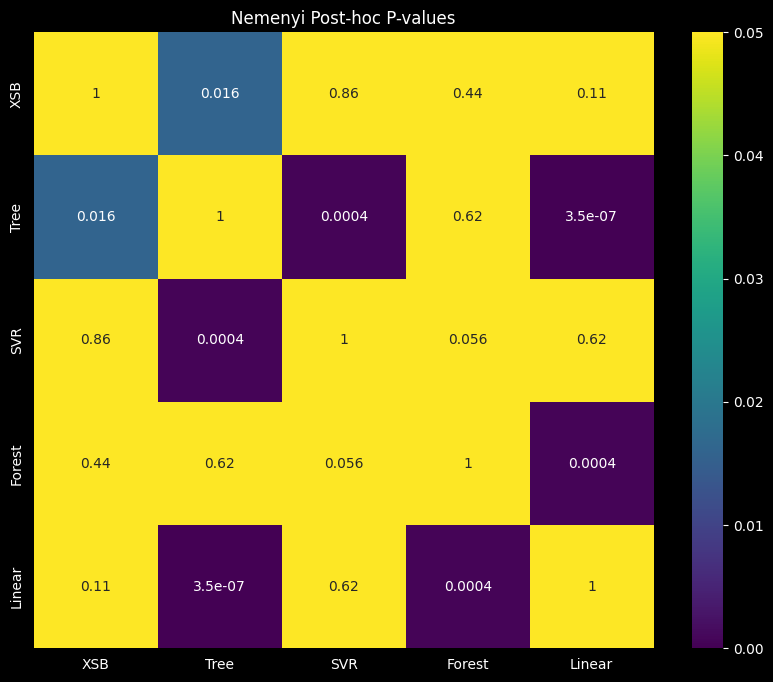

In [7]:
import scikit_posthocs as sp
import seaborn as sns

nemenyi_results = sp.posthoc_nemenyi_friedman(results_df.T)


plt.figure(figsize=(10, 8))
sns.heatmap(nemenyi_results, annot=True, cmap='viridis', vmin=0, vmax=0.05)
plt.title("Nemenyi Post-hoc P-values")
plt.show()

# Critical Difference Diagram
Instead of looking at a model's actual score, we look at how it performed relative to the others.

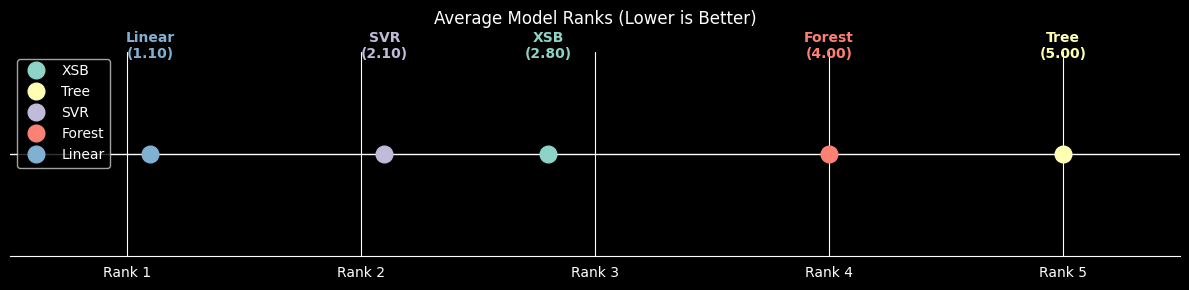

In [24]:
import matplotlib.pyplot as plt


# Higher R2 = Better Rank (closer to 1)
avg_ranks = results_df.T.rank(axis=1, ascending=False).mean()
model_names = avg_ranks.index
ranks = avg_ranks.values


fig, ax = plt.subplots(figsize=(12, 3))


ax.axhline(0, color='white', linewidth=1, zorder=1)
for i, name in enumerate(model_names):
    p = ax.plot(ranks[i], 0, 'o', markersize=12, label=name, zorder=2)
    color = p[0].get_color()
    ax.text(ranks[i], 0.05, f"{name}\n({ranks[i]:.2f})",
            ha='center', va='bottom', fontweight='bold', color=color)

num_models = len(model_names)
ax.set_xlim(0.5, num_models + 0.5)
ax.set_xticks(range(1, num_models + 1))

# Formatting for dark/standard themes
ax.set_xticklabels([f"Rank {i}" for i in range(1, num_models + 1)])
ax.get_yaxis().set_visible(False)
for spine in ['left', 'right', 'top']:
    ax.spines[spine].set_visible(False)

plt.title("Average Model Ranks (Lower is Better)", pad=20)
plt.tight_layout()
plt.legend()
plt.show()

## Summary
As the Nemenyi test shows no significant differance between Linear, SVR and XGBoost models, the Critical Difference plot enures as the linear model is the best predictor across this dataset.

# Means of Model Results

In [31]:
sorted_df = results_df.mean(axis=1).reset_index(name='Average R2_score').sort_values(by='Average R2_score', ascending=False)
sorted_df

,index,Average R2_score
4,Linear,0.665860
2,SVR,0.664174
0,XSB,0.663218
3,Forest,0.652905
1,Tree,0.622752
